In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Imports Necessary Libraries

In [2]:
import os
import cv2
import random
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image, ImageFilter
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, jaccard_score, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

# Prerequisites

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

IMG_SIZE = 256
PATCH_SIZE = 16
BATCH_SIZE = 4
EPOCHS = 10
LEARNING_RATE = 1e-4

train_img_dir = "/content/drive/MyDrive/GLH_Dataset/train/train/img"
train_mask_dir = "/content/drive/MyDrive/GLH_Dataset/train/train/label"
test_img_dir = "/content/drive/MyDrive/GLH_Dataset/test/img"
test_mask_dir = "/content/drive/MyDrive/GLH_Dataset/test/label"

# Dataset Class Defination

In [4]:
class WaterBodyDataset(Dataset):
    def __init__(self, img_dir, label_dir, transform=None):
        self.transform = transform
        self.img_files = sorted(os.listdir(img_dir))
        self.label_files = sorted(os.listdir(label_dir))
        self.pairs = []
        for img_file, label_file in zip(self.img_files, self.label_files):
            img_path = os.path.join(img_dir, img_file)
            label_path = os.path.join(label_dir, label_file)
            if not os.path.isfile(img_path) or not os.path.isfile(label_path):
                continue
            label = Image.open(label_path).convert("L").resize((IMG_SIZE, IMG_SIZE))
            if np.array(label).sum() > 0:
                self.pairs.append((img_path, label_path))

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx):
        img_path, label_path = self.pairs[idx]
        image = Image.open(img_path).convert("RGB")
        mask = Image.open(label_path).convert("L").resize((IMG_SIZE, IMG_SIZE))
        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)
        mask = (mask > 0.5).float()
        return image, mask

# Transforms Dataset

In [5]:
transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor()
])

train_dataset = WaterBodyDataset(train_img_dir, train_mask_dir, transform)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

test_dataset = WaterBodyDataset(test_img_dir, test_mask_dir, transform)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

/usr/local/lib/python3.12/dist-packages/PIL/Image.py:3452: DecompressionBombWarning: Image size (163840000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


# Vision Transformer

In [6]:
class ViTBlock(nn.Module):
    def __init__(self, dim, heads=8, mlp_dim=512, dropout=0.1):
        super().__init__()
        self.norm1 = nn.LayerNorm(dim)
        self.attn = nn.MultiheadAttention(embed_dim=dim, num_heads=heads, dropout=dropout, batch_first=True)
        self.norm2 = nn.LayerNorm(dim)
        self.mlp = nn.Sequential(
            nn.Linear(dim, mlp_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(mlp_dim, dim),
            nn.Dropout(dropout)
        )

    def forward(self, x):
        x = x + self.attn(self.norm1(x), self.norm1(x), self.norm1(x))[0]
        x = x + self.mlp(self.norm2(x))
        return x

class Encoder(nn.Module):
    def __init__(self, img_size=256, patch_size=16, in_chans=3, embed_dim=256, depth=6, num_heads=8):
        super().__init__()
        self.n_patches = (img_size // patch_size) ** 2
        self.patch_embed = nn.Conv2d(in_chans, embed_dim, kernel_size=patch_size, stride=patch_size)
        self.pos_embed = nn.Parameter(torch.randn(1, self.n_patches, embed_dim))
        self.blocks = nn.ModuleList([ViTBlock(embed_dim, heads=num_heads) for _ in range(depth)])

    def forward(self, x):
        B = x.shape[0]
        x = self.patch_embed(x)
        H, W = x.shape[2], x.shape[3]
        x = x.flatten(2).transpose(1, 2)
        x = x + self.pos_embed
        for blk in self.blocks:
            x = blk(x)
        return x, H, W

class Decoder(nn.Module):
    def __init__(self, embed_dim, output_channels=1):
        super().__init__()
        self.mlp_head = nn.Linear(embed_dim, output_channels)

    def forward(self, x, H, W):
        B, N, C = x.shape
        x = self.mlp_head(x)
        x = x.transpose(1, 2).reshape(B, 1, H, W)
        x = torch.sigmoid(nn.functional.interpolate(x, size=(IMG_SIZE, IMG_SIZE), mode="bilinear"))
        return x

class ViTSegmentation(nn.Module):
    def __init__(self, img_size=256, patch_size=16, in_chans=3, embed_dim=256, depth=6):
        super().__init__()
        self.encoder = Encoder(img_size, patch_size, in_chans, embed_dim, depth)
        self.decoder = Decoder(embed_dim)

    def forward(self, x):
        x, H, W = self.encoder(x)
        return self.decoder(x, H, W)

# Hybrid Loss

In [7]:
class DiceLoss(nn.Module):
    def __init__(self, smooth=1.0):
        super().__init__()
        self.smooth = smooth
    def forward(self, y_pred, y_true):
        y_pred = y_pred.view(-1)
        y_true = y_true.view(-1)
        intersection = (y_pred * y_true).sum()
        return 1 - (2*intersection+self.smooth)/(y_pred.sum()+y_true.sum()+self.smooth)

class TverskyLoss(nn.Module):
    def __init__(self, alpha=0.5, beta=0.5, smooth=1.0):
        super().__init__()
        self.alpha = alpha
        self.beta = beta
        self.smooth = smooth
    def forward(self, y_pred, y_true):
        y_pred = y_pred.view(-1)
        y_true = y_true.view(-1)
        TP = (y_pred*y_true).sum()
        FP = ((1-y_true)*y_pred).sum()
        FN = (y_true*(1-y_pred)).sum()
        return 1 - (TP+self.smooth)/(TP+self.alpha*FP+self.beta*FN+self.smooth)

class HybridLoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.bce = nn.BCELoss()
        self.dice = DiceLoss()
        self.tversky = TverskyLoss()
    def forward(self, y_pred, y_true):
        return 0.3*self.bce(y_pred, y_true) + 0.3*self.dice(y_pred, y_true) + 0.4*self.tversky(y_pred, y_true)


# Metrices

In [8]:
def calc_metrics(y_true, y_pred):
    y_true = y_true.view(-1).cpu().numpy()
    y_pred = (y_pred.view(-1)>0.5).cpu().numpy()
    return {
        'accuracy': accuracy_score(y_true, y_pred),
        'precision': precision_score(y_true, y_pred, zero_division=0),
        'recall': recall_score(y_true, y_pred, zero_division=0),
        'f1_score': f1_score(y_true, y_pred, zero_division=0),
        'iou_score': jaccard_score(y_true, y_pred, zero_division=0),
        'confusion_matrix': confusion_matrix(y_true, y_pred)
    }

# Model Training Pipeline

In [9]:
model = ViTSegmentation(img_size=IMG_SIZE, patch_size=PATCH_SIZE).to(device)
criterion = HybridLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

train_losses, val_losses = [], []
metrics_history = {'accuracy': [], 'precision': [], 'recall': [], 'f1_score': [], 'iou_score': []}

for epoch in range(EPOCHS):
    model.train()
    total_loss = 0
    for imgs, masks in tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS}"):
        imgs, masks = imgs.to(device), masks.to(device)
        outputs = model(imgs)
        loss = criterion(outputs, masks)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    train_losses.append(total_loss / len(train_loader))

    # Validation
    model.eval()
    val_loss, metrics_epoch = 0, []
    with torch.no_grad():
        for imgs, masks in test_loader:
            imgs, masks = imgs.to(device), masks.to(device)
            outputs = model(imgs)
            val_loss += criterion(outputs, masks).item()
            metrics_epoch.append(calc_metrics(masks, outputs))
    val_losses.append(val_loss / len(test_loader))
    avg_metrics = {k: np.mean([m[k] for m in metrics_epoch]) for k in metrics_history}
    for k in metrics_history:
        metrics_history[k].append(avg_metrics[k])
    print(f"\nEpoch {epoch+1}: TrainLoss={train_losses[-1]:.4f}, ValLoss={val_losses[-1]:.4f}")
    print(f"Acc: {avg_metrics['accuracy']:.4f}, Prec: {avg_metrics['precision']:.4f}, "
          f"Rec: {avg_metrics['recall']:.4f}, F1: {avg_metrics['f1_score']:.4f}, IoU: {avg_metrics['iou_score']:.4f}")

# Save trained model
torch.save(model.state_dict(), "vit_waterbody.pth")

Epoch 1/10: 100%|██████████| 35/35 [10:33<00:00, 18.11s/it]
/usr/local/lib/python3.12/dist-packages/PIL/Image.py:3452: DecompressionBombWarning: Image size (163840000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/PIL/Image.py:3452: DecompressionBombWarning: Image size (163840000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/PIL/Image.py:3452: DecompressionBombWarning: Image size (163840000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/PIL/Image.py:3452: DecompressionBombWarning: Image size (163840000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/PIL/Image.py:3452: DecompressionBombWarning: Image size (163840000 pixels) e


Epoch 1: TrainLoss=0.6441, ValLoss=0.6573
Acc: 0.7928, Prec: 0.5176, Rec: 0.1345, F1: 0.2097, IoU: 0.1221


Epoch 2/10:   0%|          | 0/35 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:3452: DecompressionBombWarning: Image size (163840000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
Epoch 2/10: 100%|██████████| 35/35 [07:36<00:00, 13.03s/it]
/usr/local/lib/python3.12/dist-packages/PIL/Image.py:3452: DecompressionBombWarning: Image size (163840000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/PIL/Image.py:3452: DecompressionBombWarning: Image size (163840000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/PIL/Image.py:3452: DecompressionBombWarning: Image size (163840000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/PIL/Image.py:3452: Decompr


Epoch 2: TrainLoss=0.5657, ValLoss=0.6196
Acc: 0.7931, Prec: 0.4882, Rec: 0.3339, F1: 0.3920, IoU: 0.2596


Epoch 3/10:   0%|          | 0/35 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:3452: DecompressionBombWarning: Image size (163840000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
Epoch 3/10: 100%|██████████| 35/35 [07:36<00:00, 13.05s/it]
/usr/local/lib/python3.12/dist-packages/PIL/Image.py:3452: DecompressionBombWarning: Image size (163840000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/PIL/Image.py:3452: DecompressionBombWarning: Image size (163840000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/PIL/Image.py:3452: DecompressionBombWarning: Image size (163840000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/PIL/Image.py:3452: Decompr


Epoch 3: TrainLoss=0.5317, ValLoss=0.5982
Acc: 0.7851, Prec: 0.4730, Rec: 0.4029, F1: 0.4276, IoU: 0.2894


Epoch 4/10:   0%|          | 0/35 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:3452: DecompressionBombWarning: Image size (163840000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
Epoch 4/10: 100%|██████████| 35/35 [07:39<00:00, 13.12s/it]
/usr/local/lib/python3.12/dist-packages/PIL/Image.py:3452: DecompressionBombWarning: Image size (163840000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/PIL/Image.py:3452: DecompressionBombWarning: Image size (163840000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/PIL/Image.py:3452: DecompressionBombWarning: Image size (163840000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/PIL/Image.py:3452: Decompr


Epoch 4: TrainLoss=0.5441, ValLoss=0.5997
Acc: 0.7820, Prec: 0.4705, Rec: 0.4230, F1: 0.4367, IoU: 0.2964


Epoch 5/10:   0%|          | 0/35 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:3452: DecompressionBombWarning: Image size (163840000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
Epoch 5/10: 100%|██████████| 35/35 [07:37<00:00, 13.07s/it]
/usr/local/lib/python3.12/dist-packages/PIL/Image.py:3452: DecompressionBombWarning: Image size (163840000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/PIL/Image.py:3452: DecompressionBombWarning: Image size (163840000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/PIL/Image.py:3452: DecompressionBombWarning: Image size (163840000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/PIL/Image.py:3452: Decompr


Epoch 5: TrainLoss=0.5164, ValLoss=0.6363
Acc: 0.7866, Prec: 0.5121, Rec: 0.2587, F1: 0.3280, IoU: 0.2035


Epoch 6/10:   0%|          | 0/35 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:3452: DecompressionBombWarning: Image size (163840000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
Epoch 6/10: 100%|██████████| 35/35 [07:37<00:00, 13.07s/it]
/usr/local/lib/python3.12/dist-packages/PIL/Image.py:3452: DecompressionBombWarning: Image size (163840000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/PIL/Image.py:3452: DecompressionBombWarning: Image size (163840000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/PIL/Image.py:3452: DecompressionBombWarning: Image size (163840000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/PIL/Image.py:3452: Decompr


Epoch 6: TrainLoss=0.5107, ValLoss=0.6054
Acc: 0.7765, Prec: 0.4796, Rec: 0.3587, F1: 0.3882, IoU: 0.2490


Epoch 7/10:   0%|          | 0/35 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:3452: DecompressionBombWarning: Image size (163840000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
Epoch 7/10: 100%|██████████| 35/35 [07:34<00:00, 12.98s/it]
/usr/local/lib/python3.12/dist-packages/PIL/Image.py:3452: DecompressionBombWarning: Image size (163840000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/PIL/Image.py:3452: DecompressionBombWarning: Image size (163840000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/PIL/Image.py:3452: DecompressionBombWarning: Image size (163840000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/PIL/Image.py:3452: Decompr


Epoch 7: TrainLoss=0.4843, ValLoss=0.6454
Acc: 0.7885, Prec: 0.5528, Rec: 0.2576, F1: 0.3242, IoU: 0.2018


Epoch 8/10:   0%|          | 0/35 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:3452: DecompressionBombWarning: Image size (163840000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
Epoch 8/10: 100%|██████████| 35/35 [07:37<00:00, 13.06s/it]
/usr/local/lib/python3.12/dist-packages/PIL/Image.py:3452: DecompressionBombWarning: Image size (163840000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/PIL/Image.py:3452: DecompressionBombWarning: Image size (163840000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/PIL/Image.py:3452: DecompressionBombWarning: Image size (163840000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/PIL/Image.py:3452: Decompr


Epoch 8: TrainLoss=0.4917, ValLoss=0.6086
Acc: 0.7812, Prec: 0.5073, Rec: 0.3438, F1: 0.3809, IoU: 0.2426


Epoch 9/10:   0%|          | 0/35 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:3452: DecompressionBombWarning: Image size (163840000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
Epoch 9/10: 100%|██████████| 35/35 [07:33<00:00, 12.96s/it]
/usr/local/lib/python3.12/dist-packages/PIL/Image.py:3452: DecompressionBombWarning: Image size (163840000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/PIL/Image.py:3452: DecompressionBombWarning: Image size (163840000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/PIL/Image.py:3452: DecompressionBombWarning: Image size (163840000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/PIL/Image.py:3452: Decompr


Epoch 9: TrainLoss=0.4674, ValLoss=0.6407
Acc: 0.7837, Prec: 0.5315, Rec: 0.3314, F1: 0.3713, IoU: 0.2348


Epoch 10/10:   0%|          | 0/35 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:3452: DecompressionBombWarning: Image size (163840000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
Epoch 10/10: 100%|██████████| 35/35 [07:34<00:00, 12.99s/it]
/usr/local/lib/python3.12/dist-packages/PIL/Image.py:3452: DecompressionBombWarning: Image size (163840000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/PIL/Image.py:3452: DecompressionBombWarning: Image size (163840000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/PIL/Image.py:3452: DecompressionBombWarning: Image size (163840000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/PIL/Image.py:3452: Decom


Epoch 10: TrainLoss=0.4679, ValLoss=0.6094
Acc: 0.7881, Prec: 0.5502, Rec: 0.3134, F1: 0.3650, IoU: 0.2312


# Visualizations

In [10]:
model.eval()
all_preds, all_labels, all_probs = [], [], []
with torch.no_grad():
    for imgs, masks in test_loader:
        imgs, masks = imgs.to(device), masks.to(device)
        outputs = model(imgs)
        probs = outputs.cpu().view(-1).numpy()
        preds = (probs>0.5).astype(int)
        labels = masks.cpu().view(-1).numpy()
        all_preds.extend(preds)
        all_labels.extend(labels)
        all_probs.extend(probs)

/usr/local/lib/python3.12/dist-packages/PIL/Image.py:3452: DecompressionBombWarning: Image size (163840000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


## Confusion matrix

In [ ]:
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted"); plt.ylabel("True")
plt.show()

## Loss plot

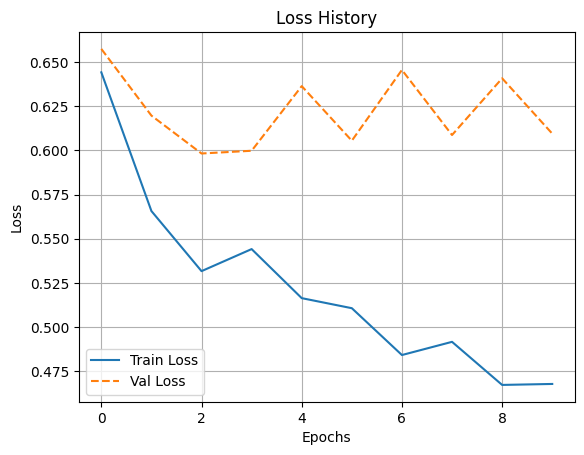

In [12]:
plt.figure()
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss", linestyle='--')
plt.title("Loss History"); plt.xlabel("Epochs"); plt.ylabel("Loss")
plt.legend(); plt.grid(True); plt.show()

## Metric trends

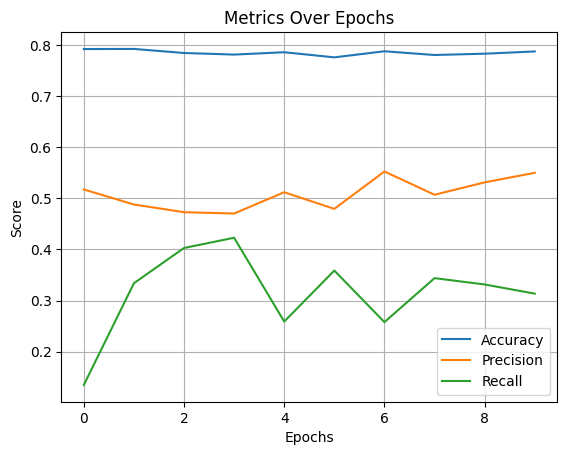

In [13]:
plt.figure()
plt.plot(metrics_history['accuracy'], label="Accuracy")
plt.plot(metrics_history['precision'], label="Precision")
plt.plot(metrics_history['recall'], label="Recall")
plt.title("Metrics Over Epochs")
plt.xlabel("Epochs"); plt.ylabel("Score"); plt.legend(); plt.grid(True); plt.show()

## IoU trend

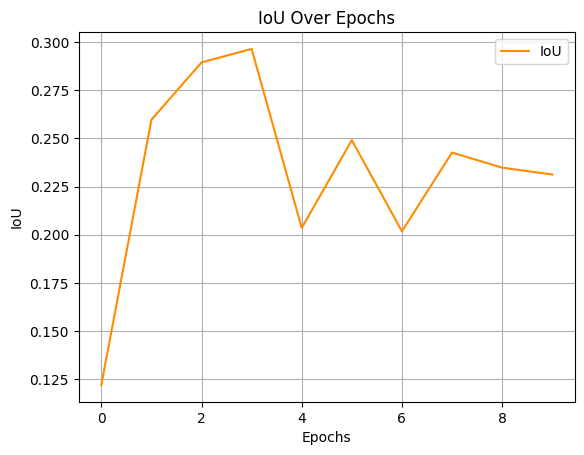

In [14]:
plt.figure()
plt.plot(metrics_history['iou_score'], label="IoU", color="darkorange")
plt.title("IoU Over Epochs")
plt.xlabel("Epochs"); plt.ylabel("IoU")
plt.grid(True); plt.legend(); plt.show()

## ROC Curve

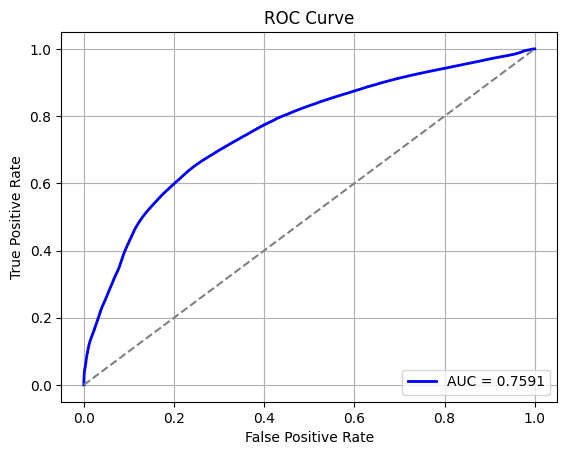

In [15]:
fpr, tpr, _ = roc_curve(all_labels, all_probs)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f"AUC = {roc_auc:.4f}")
plt.plot([0,1],[0,1], color="gray", linestyle="--")
plt.title("ROC Curve"); plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
plt.legend(loc="lower right"); plt.grid(True); plt.show()

## Water Bodies Segmentation Visuals  

/usr/local/lib/python3.12/dist-packages/PIL/Image.py:3452: DecompressionBombWarning: Image size (163840000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


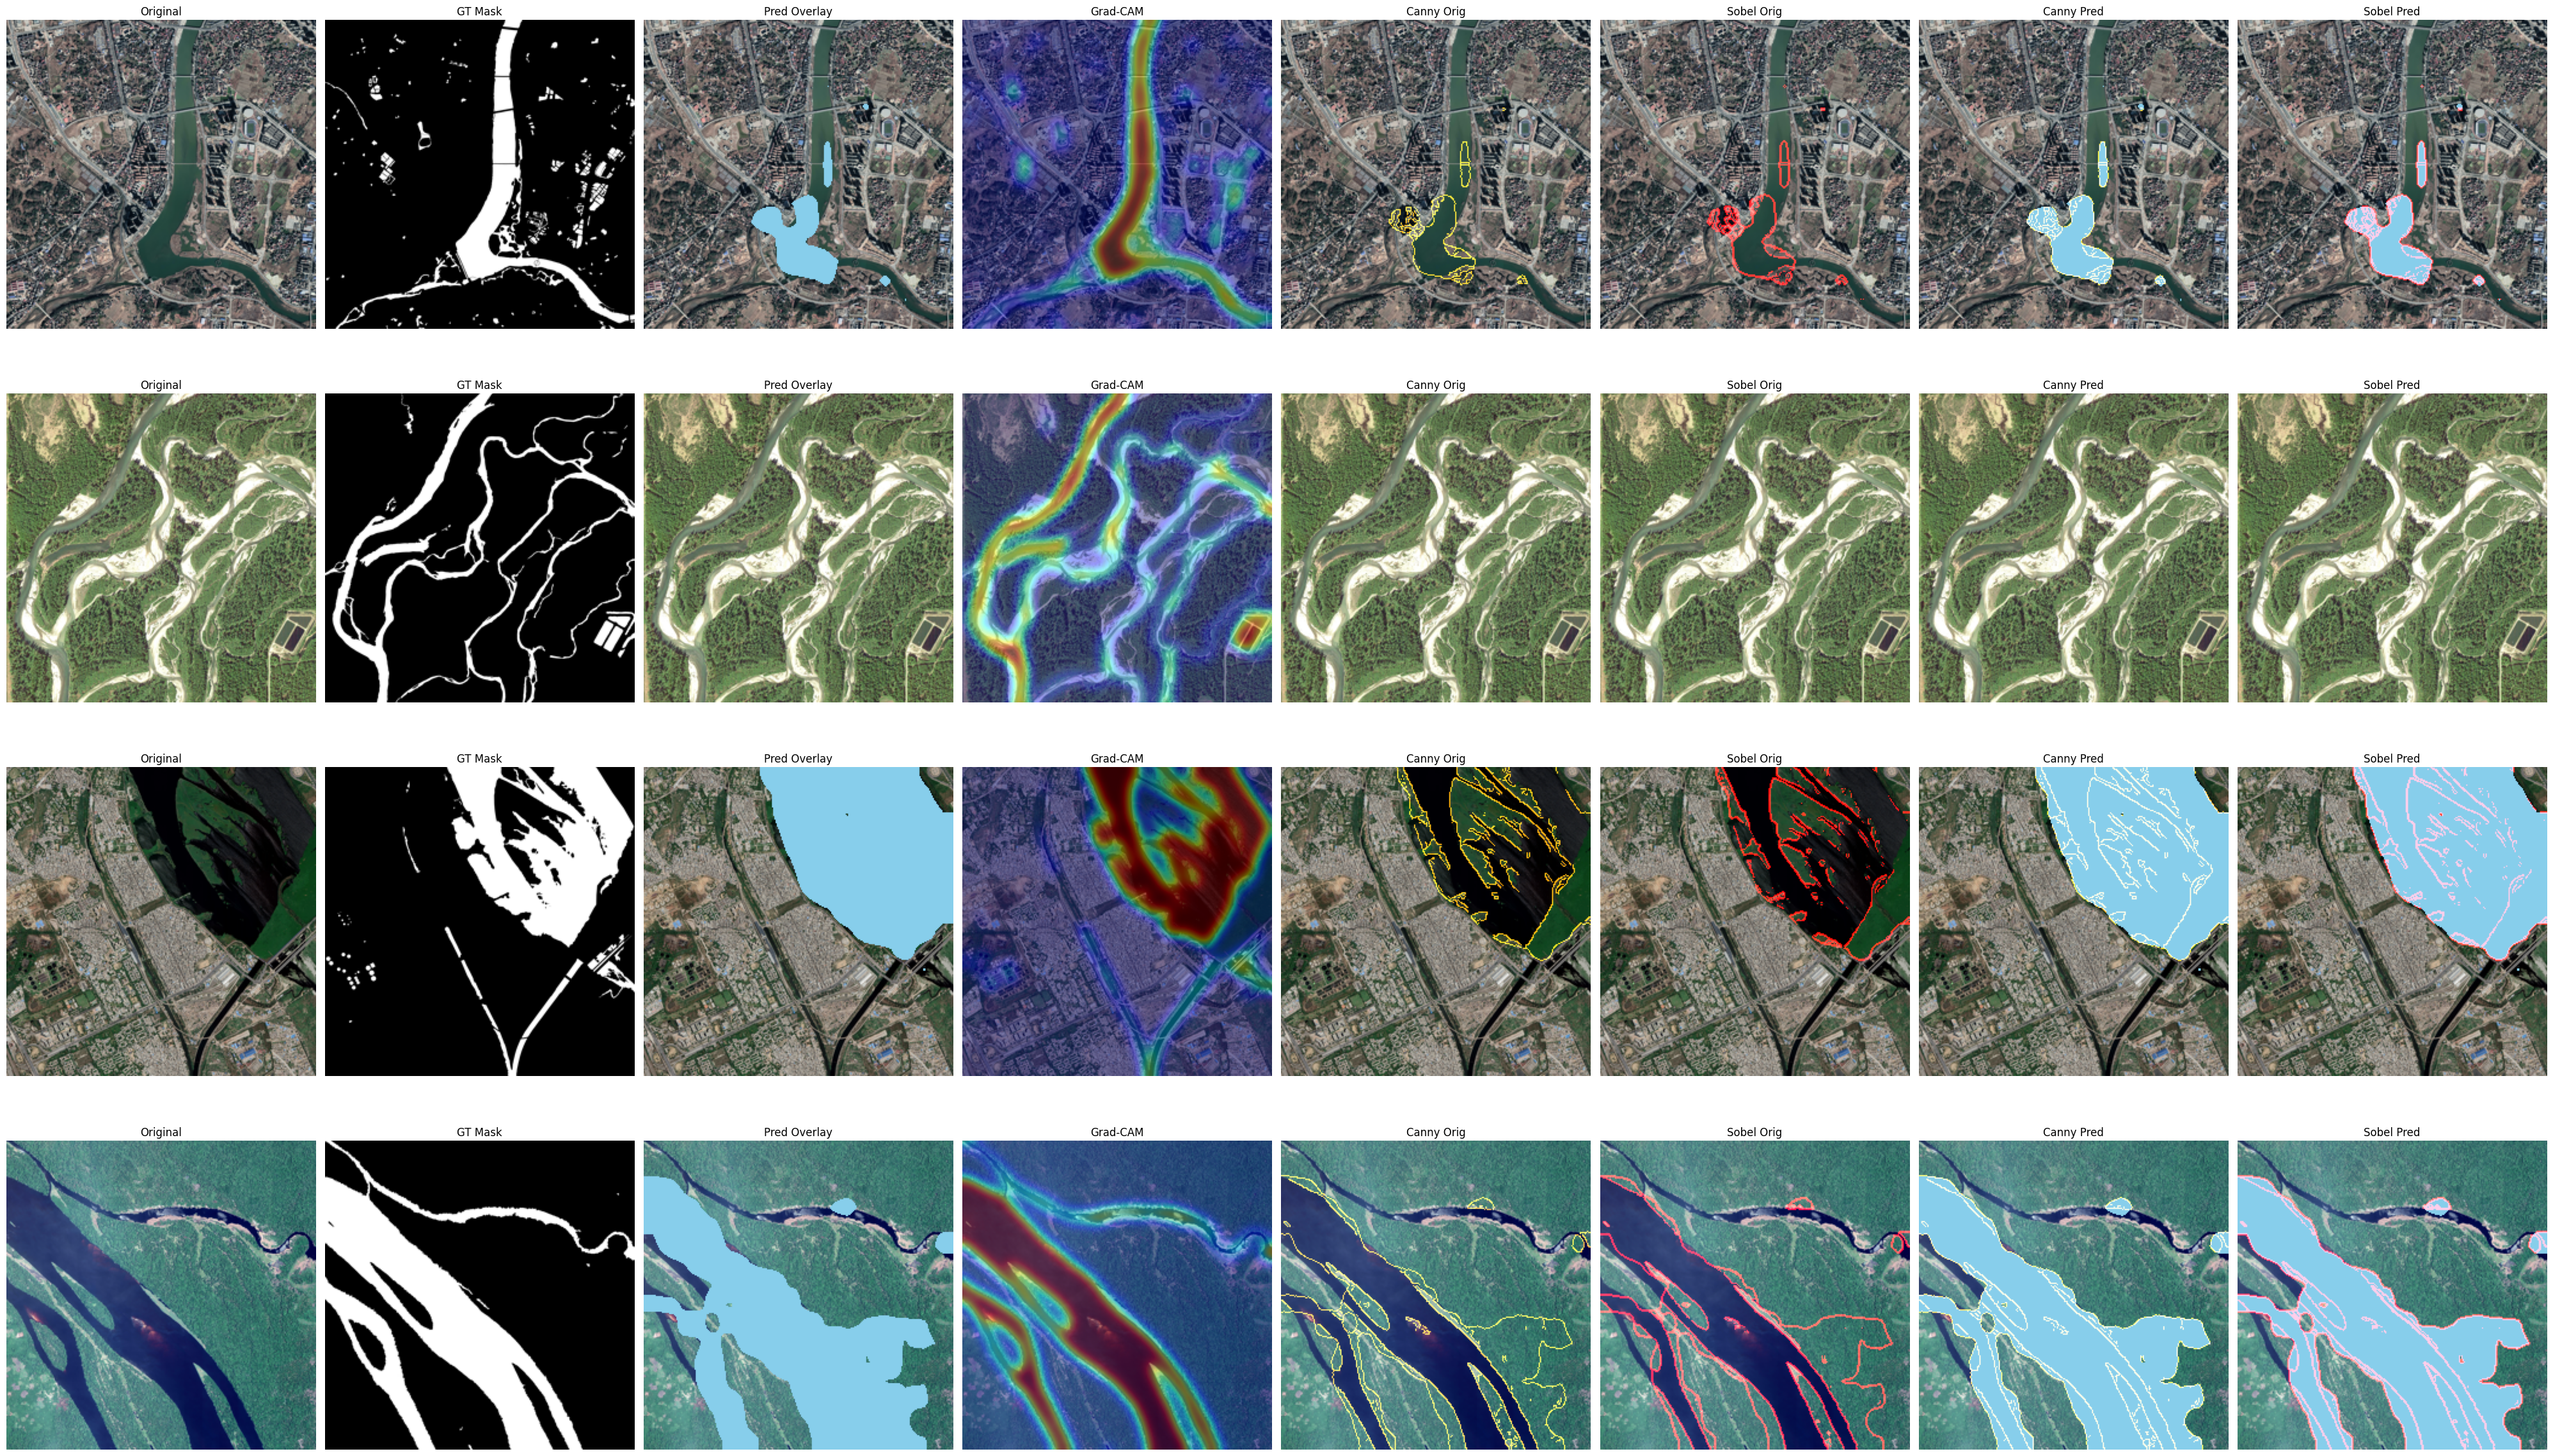

In [16]:
test_img_dict = {os.path.splitext(f)[0]: f for f in os.listdir(test_img_dir) if f.endswith((".jpg",".png"))}
test_mask_dict = {os.path.splitext(f)[0]: f for f in os.listdir(test_mask_dir) if f.endswith(".png")}
common_keys = list(set(test_img_dict.keys()) & set(test_mask_dict.keys()))
valid_keys = [k for k in common_keys if np.any(np.array(Image.open(os.path.join(test_mask_dir, test_mask_dict[k])).convert("L").resize((IMG_SIZE, IMG_SIZE)))>127)]
selected_keys = random.sample(valid_keys, min(4,len(valid_keys)))
sky_blue = np.array([135,206,235])/255.0

plt.figure(figsize=(40, 6*len(selected_keys)))

for i, key in enumerate(selected_keys):
    img = Image.open(os.path.join(test_img_dir, test_img_dict[key])).convert("RGB").resize((IMG_SIZE, IMG_SIZE))
    label = Image.open(os.path.join(test_mask_dir, test_mask_dict[key])).convert("L").resize((IMG_SIZE, IMG_SIZE))

    img_tensor = transform(img).unsqueeze(0).to(device)
    with torch.no_grad():
        pred_mask = (model(img_tensor).squeeze().cpu().numpy() > 0.5).astype(np.uint8)

    gt_mask = (np.array(label)>127).astype(np.uint8)
    img_np = np.array(img)/255.0
    pred_overlay = img_np.copy(); pred_overlay[pred_mask==1]=sky_blue
    pred_overlay_uint8 = (pred_overlay*255).astype(np.uint8)

    grad_cam_np = np.array(label.filter(ImageFilter.GaussianBlur(radius=5))).astype(np.float32)
    grad_cam_np = (grad_cam_np - grad_cam_np.min())/(grad_cam_np.max()-grad_cam_np.min()+1e-6)
    heatmap = plt.get_cmap("jet")(grad_cam_np)[:,:,:3]
    grad_cam_overlay = 0.6*img_np + 0.4*heatmap

    gray_img = cv2.cvtColor((img_np*255).astype(np.uint8), cv2.COLOR_RGB2GRAY)
    masked_gray = gray_img.copy(); masked_gray[pred_mask==0]=0
    canny_edges = cv2.Canny(masked_gray,100,200)
    sobelx = cv2.Sobel(masked_gray, cv2.CV_64F,1,0,3); sobely = cv2.Sobel(masked_gray, cv2.CV_64F,0,1,3)
    sobel_edges = cv2.magnitude(sobelx,sobely); sobel_edges = ((sobel_edges/(sobel_edges.max()+1e-6))*255).astype(np.uint8)
    sobel_edges = (sobel_edges>50).astype(np.uint8)*255
    def overlay_edges(base,edges,color):
        canvas = np.zeros_like(base); canvas[edges>0]=color
        return cv2.addWeighted(base,1.0,canvas,1.0,0)

    canny_on_orig = overlay_edges((img_np*255).astype(np.uint8), canny_edges, [255,165,0])
    sobel_on_orig = overlay_edges((img_np*255).astype(np.uint8), sobel_edges, [255,0,0])
    canny_on_pred = overlay_edges(pred_overlay_uint8, canny_edges, [255,165,0])
    sobel_on_pred = overlay_edges(pred_overlay_uint8, sobel_edges, [255,0,0])

    plt.subplot(len(selected_keys),8,8*i+1); plt.imshow(img_np); plt.title("Original"); plt.axis("off")
    plt.subplot(len(selected_keys),8,8*i+2); plt.imshow(label,cmap="gray"); plt.title("GT Mask"); plt.axis("off")
    plt.subplot(len(selected_keys),8,8*i+3); plt.imshow(pred_overlay_uint8); plt.title("Pred Overlay"); plt.axis("off")
    plt.subplot(len(selected_keys),8,8*i+4); plt.imshow(grad_cam_overlay); plt.title("Grad-CAM"); plt.axis("off")
    plt.subplot(len(selected_keys),8,8*i+5); plt.imshow(canny_on_orig); plt.title("Canny Orig"); plt.axis("off")
    plt.subplot(len(selected_keys),8,8*i+6); plt.imshow(sobel_on_orig); plt.title("Sobel Orig"); plt.axis("off")
    plt.subplot(len(selected_keys),8,8*i+7); plt.imshow(canny_on_pred); plt.title("Canny Pred"); plt.axis("off")
    plt.subplot(len(selected_keys),8,8*i+8); plt.imshow(sobel_on_pred); plt.title("Sobel Pred"); plt.axis("off")

plt.tight_layout(); plt.show()
